# Preprocessing: Baseline ARIMA model for Cardano(ADA) 

## Overview: 

Up to this point, we have seen that Cardano has had a volatile 4-years since it's inception. It has increased in value exponentially within the first few months of it being listed on exchanges to purchase and trade. It has grown from being worth less than half a billion dollars to over forty billion dollars in marketcap in just four years. 

As outlined in the EDA notebook, Cardano's success is largely contingent upon the direction Bitcoin is moving in the market. If Bitcoin is on a downward trajectory, Cardano will follow; the same can be said for movement to the upside. Even though the usecase for each cryptocurrency is so different, with Bitcoin being primarily the 'gold' of digital currency and Cardano creating and attempting to roll out their blockchain to trade, purchase and sell digital goods, Bitcoin's movement determines the value of Cardano for those attempting to make profit off of trading. 

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Test for data stationarity with KPSS
- Make the ARIMA Model
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps

# 1. Sourcing and Loading 

In [1]:
# import and load libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# load df and print first 10 rows
ADA_df = pd.read_csv('../Capstone_Project_3/Data/ADA_df.csv')
ADA_df.head()

,Unnamed: 0,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,0,ADA,2017-10-02,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,1,ADA,2017-10-03,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,2,ADA,2017-10-04,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,3,ADA,2017-10-05,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,4,ADA,2017-10-06,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


In [3]:
#check dtypes
ADA_df.dtypes

Unnamed: 0      int64
Symbol         object
Date           object
High          float64
Low           float64
Open          float64
Close         float64
Volume        float64
Marketcap     float64
dtype: object

# 2. Cleaning, Transforming, Visualizing

In [4]:
#create df with only 'Date' and 'Close'
df = ADA_df[['Date', 'Close']]
df.head()

,Date,Close
0,2017-10-02,0.025932
1,2017-10-03,0.020816
2,2017-10-04,0.021931
3,2017-10-05,0.021489
4,2017-10-06,0.018539


In [5]:
#change 'Date' to 'Day' since the granularity is 24 hours. 
df = df.rename(columns={'Date':'Day', 'Close':'Price'})
df.tail()

,Day,Price
1240,2021-02-23,0.954709
1241,2021-02-24,1.051657
1242,2021-02-25,1.079116
1243,2021-02-26,1.241105
1244,2021-02-27,1.324860


In [6]:
#convert 'Day' from an object to a datetime64. 
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace = True)

In [7]:
#make 'Price' the predictor variable 'y' and check data type
y = df['Price']
y.dtypes

dtype('float64')

In [8]:
#get summary statistics of 'y'
y.describe()

count    1245.000000
mean        0.138757
std         0.177812
min         0.018539
25%         0.044328
50%         0.080952
75%         0.143573
max         1.324860
Name: Price, dtype: float64

<AxesSubplot:xlabel='Day'>

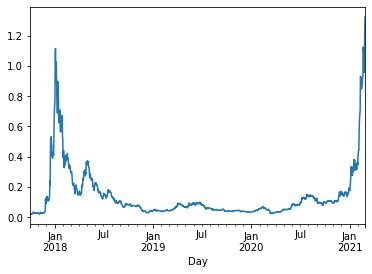

In [9]:
# plot 'y'
y.plot()

# 3. Modeling
## Decomposition

**Trend**: ADA does have an upward trend from when it began to this point. It looks as though once a peak has formed you can expect extreme downward motion. 
**Seasonality**: It does not look like there is seasonality that can be intuited from this representation. 
**Noise**: There is quite a bit of variance in the price. 

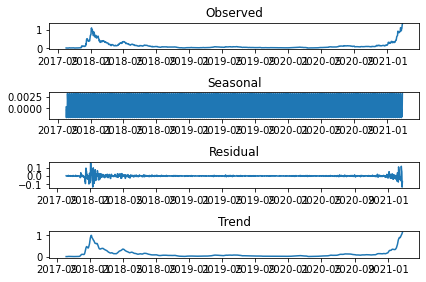

In [10]:
#plot the seasonality, trend, and residuals compared to the observed line
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
observed = decomposition.observed
seasonal = decomposition.seasonal
residual = decomposition.resid
trend = decomposition.trend

plt.subplot(411)
plt.title('Observed')
plt.plot(observed, label='Observed')
plt.subplot(412)
plt.title('Seasonal')
plt.plot(seasonal, label='Seasonal')
plt.subplot(413)
plt.title('Residual')
plt.plot(residual, label='Residual')
plt.subplot(414)
plt.title('Trend')
plt.plot(trend, label='Trend')
plt.tight_layout(pad=1)

In [11]:
#check for stationarity
from statsmodels.tsa.stattools import kpss
kpss(y)

/Users/Reeves1/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


(0.5568613792080169,
 0.02886004972792411,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

With the p-value being less than .05, we can reject the null hypothesis and assume that our data is not stationary. 

<AxesSubplot:xlabel='Day'>

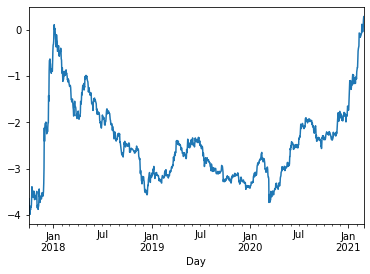

In [12]:
# log transformation to account for variance in the data
y_log = np.log(y)
y_log.plot()

In [13]:
#with the variance addressed, we must address the lack of a constant mean. 
#.diff() function on y_log should do the trick. 
import warnings
warnings.filterwarnings("ignore")
kpss(y_log.diff().dropna())

(0.21929158236343513,
 0.1,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The p-value is now above .05, indicating the constant mean and constant variance has been effected in a way that can allow us to accept the null hypothesis that the stationarity of the data is acceptable. This also implies that the d-value for the ARIMA model is 1. 

In [23]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA

In [52]:
# Train/Test split at 85/15, with the intent of tuning the parameters on the training data to find the best model.
split=int(len(y_log) * 0.8) 
y_train, y_test = y_log[0:split], y_log[split:len(y_log)]

In [53]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(train, test, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    #split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    #train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_absolute_error(test, predictions)
    # Return the error
    return error

In [54]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    split=int(len(dataset) * 0.9) 
                    train, test = dataset[0:split], dataset[split:len(dataset)]
                    mae = evaluate_arima_model(train, test, order)
                    if mae < best_score:
                        best_score, best_cfg = mae, order
                    print('ARIMA%s MAE=%.3f' % (order,mae))
                except:
                    continue
    return print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))

In [55]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]
evaluate_models(y_train, p_values, d_values, q_values)

ARIMA(0, 0, 0) MAE=0.516
ARIMA(0, 0, 1) MAE=0.280
ARIMA(0, 1, 0) MAE=0.038
ARIMA(0, 1, 1) MAE=0.038
ARIMA(0, 1, 2) MAE=0.038
ARIMA(0, 2, 0) MAE=0.065
ARIMA(0, 2, 1) MAE=0.040
ARIMA(0, 2, 2) MAE=0.040
ARIMA(1, 0, 0) MAE=0.038
ARIMA(1, 0, 1) MAE=0.038
ARIMA(1, 0, 2) MAE=0.038
ARIMA(1, 1, 0) MAE=0.038
ARIMA(1, 1, 1) MAE=0.039
ARIMA(1, 1, 2) MAE=0.038
ARIMA(1, 2, 0) MAE=0.049
ARIMA(1, 2, 1) MAE=0.039
ARIMA(1, 2, 2) MAE=0.039
ARIMA(2, 0, 0) MAE=0.038
ARIMA(2, 0, 1) MAE=0.038
ARIMA(2, 0, 2) MAE=0.038
ARIMA(2, 1, 0) MAE=0.038
ARIMA(2, 1, 1) MAE=0.038
ARIMA(2, 1, 2) MAE=0.038
ARIMA(2, 2, 0) MAE=0.047
ARIMA(2, 2, 1) MAE=0.039
ARIMA(2, 2, 2) MAE=0.039
Best ARIMA(1, 0, 2) MAE=0.038


In [58]:
#build model with parameters set to Best ARIMA findings above, except using 1 for the d-value. 
p=1
d=1
q=2
model = ARIMA(y_test, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(30)

In [59]:
#summary of model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  248
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 325.960
Method:                       css-mle   S.D. of innovations              0.065
Date:                Fri, 02 Jul 2021   AIC                           -641.920
Time:                        10:42:58   BIC                           -624.353
Sample:                    06-25-2020   HQIC                          -634.848
                         - 02-27-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0135      0.008      1.596      0.111      -0.003       0.030
ar.L1.D.Price     0.9834      0.023     43.692      0.000       0.939       1.027
ma.L1.D.Price    -0.9925      0.067    -14.871      0.000      -1.123      -0.862
ma.L2.D.Price     0.0290      0.062      0.467      0.641      -0.093       0.151
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0169           +0.0000j            1.0169            0.0000
MA.1            1.0392           +0.0000j            1.0392            0.0000
MA.2           33.1358           +0.0000j           33.1358            0.0000
-----------------------------------------------------------------------------
"""

In [101]:
# create dataframe comparing results of test data to the pred data. 
Test_Orig_Price = np.exp(y_test)
Log_Y_Test = y_test
Pred_Log_Y = model_fit.predict()
Pred_Price = np.exp(Pred_Log_Y)
Residuals = Test_Orig_Price - Pred_Price

df[['Test_Orig_Price', 'Log_Y_Test', 'Pred_Log_Y', 'Pred_Price', 'Residuals']] = Test_Orig_Price, Log_Y_Test, Pred_Log_Y, Pred_Price, Residuals
df_pred = df.drop(['Price', 'y_log'], axis=1).dropna()
df_pred

,Test_Orig_Price,Log_Y_Test,Pred_Log_Y,Pred_Price,Residuals
Day,,,,,
2020-06-25,0.081691,-2.504812,0.013518,1.013610,-0.931919
2020-06-26,0.080561,-2.518741,0.013453,1.013544,-0.932983
2020-06-27,0.077679,-2.555176,0.012685,1.012765,-0.935087
2020-06-28,0.080392,-2.520843,0.011834,1.011904,-0.931512
2020-06-29,0.083870,-2.478491,0.010467,1.010522,-0.926653
...,...,...,...,...,...
2021-02-23,0.954709,-0.046349,0.024532,1.024835,-0.070126
2021-02-24,1.051657,0.050367,0.025076,1.025393,0.026263
2021-02-25,1.079116,0.076142,0.019426,1.019616,0.059500


Text(0.5, 0, 'Difference between Test and Prediction')

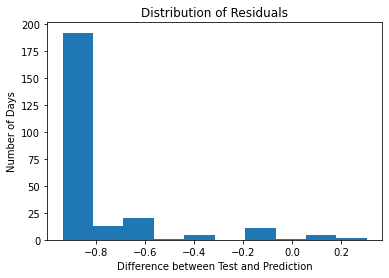

In [103]:
plt.hist(df_pred['Residuals'])
plt.title('Distribution of Residuals')
plt.ylabel('Number of Days')
plt.xlabel('Difference between Test and Prediction')

As is shown in the above histogram, the model is struggling to accurately fit the predicted line closely to what the actual data shows us. This could be a result of the lack of seasonality in the data, the abruptness of the massive trends in the data, etc. Seeing how other forecasting models handle this diff